# **Загрузка данных**

In [1]:
from glob import glob
import os
import pandas as pd
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.stats import uniform
from numpy import random

seed = 1
random.seed(seed)

In [2]:
data_path = "data/population.xls"
# train_data = pathlib.Path("data/population.xls")
data = pd.read_excel(data_path)

In [3]:
data.head()

,year,population,town,country,town%,country%
0,1970,129.9,80.6,49.3,62,38
1,1971,130.6,82.0,48.6,63,37
2,1972,131.3,83.6,47.7,64,36
3,1973,132.1,85.4,46.7,65,35
4,1974,132.8,87.1,45.7,66,34


# **Анализ данных**

In [4]:
import seaborn as sns

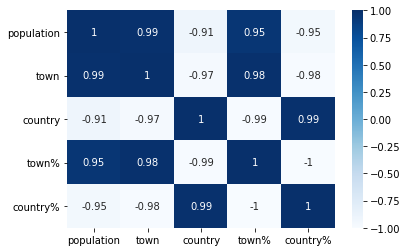

In [5]:
sns.heatmap(data.iloc[:, 1:].corr(), cbar=True, annot=True, cmap="Blues")

In [6]:
data.describe()

,year,population,town,country,town%,country%
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,1994.214286,141.576190,101.150000,40.426190,71.333333,28.666667
std,15.873795,5.293982,8.424999,3.318688,3.404922,3.404922
min,1970.000000,129.900000,80.600000,37.100000,62.000000,25.000000
25%,1980.250000,138.275000,96.400000,37.925000,70.000000,26.000000
50%,1990.500000,142.950000,105.050000,39.100000,73.000000,27.000000
75%,2008.750000,145.800000,106.675000,41.875000,74.000000,30.000000
max,2019.000000,148.300000,109.500000,49.300000,75.000000,38.000000


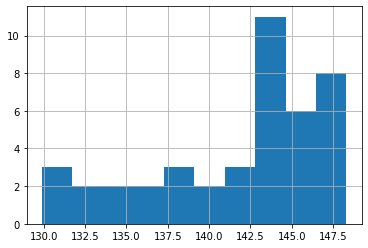

In [7]:
data.iloc[:, 1].hist(grid=True)

In [8]:
data['country'] = -data['country']
data['country%'] = -data['country%']

In [9]:
data.iloc[:, 1].value_counts().head()

146.3    2
142.9    2
146.8    2
148.3    2
142.8    2
Name: population, dtype: int64

In [10]:
# data_X = np.array(data['town']).reshape(-1, 1)
# data_y = np.array(data['population']).reshape(-1, 1)

data_X = data.iloc[:, 2:]
data_y = np.array(data['population'])

# **Генерация выборки**

In [11]:
def gen_sample(data_x, data_y, period: int = 10, future: int = 5):
    
    start = period
    end = len(data_x) - future
    
    out_X = []
    out_Y = []
    
    new_df = []
    for i in tqdm(range(start, end)):
        var_x = list(data_x.iloc[i, :].values)
        var_y = data_y[i + future]
        
        past_future = var_x + [var_y]
        
        new_df.append(past_future)

        out_X.append(var_x)
        out_Y.append(var_y)
        
    return np.array(out_X), np.array(out_Y), new_df

In [12]:
past_data = 1
future_data = 3

X, y, new_df = gen_sample(data_X, data_y, past_data, future_data)
print(X.shape, y.shape, len(new_df[0]))

100%|████████████████████████████████████████| 38/38 [00:00<00:00, 2533.19it/s]

(38, 4) (38,) 5


In [13]:
past_columns = []
for i in range(len(X[0])):
    past_columns.append(f'past_{i}')

future_columns = ['future_1']

In [14]:
transformed_df = pd.DataFrame(new_df, columns=(past_columns + future_columns))

In [15]:
transformed_df[past_columns].head()

,past_0,past_1,past_2,past_3
0,82.0,-48.6,63.0,-37.0
1,83.6,-47.7,64.0,-36.0
2,85.4,-46.7,65.0,-35.0
3,87.1,-45.7,66.0,-34.0
4,88.9,-44.7,67.0,-33.0


In [16]:
transformed_df[future_columns].head()

,future_1
0,132.8
1,133.6
2,134.5
3,135.5
4,136.5


# **Препроцессинг**

In [17]:
from sklearn.preprocessing import Normalizer

In [18]:
# transformer = Normalizer(norm='l2')
# transformer.fit(X)
# transf_X = np.array(transformer.transform(X))

transf_X = X

# **Разбиение на обучающую, валидационную и тестовую выборки**

In [19]:
test_size = 12

In [20]:
X_train, X_test, y_train, y_test = transf_X[:-test_size], transf_X[-test_size:], y[:-test_size], y[-test_size:]

hyperopt_X = X_train
hyperopt_y = y_train

X_train, X_valid, y_train, y_valid = X_train[:-test_size], X_train[-test_size:], y_train[:-test_size], y_train[-test_size:]

In [21]:
y_test

array([142.8, 142.7, 142.9, 142.9, 143. , 143.3, 143.7, 146.3, 146.5,
       146.8, 146.9, 146.8])

In [22]:
X_valid

array([[102.4, -40.1,  72. , -28. ],
       [103.7, -39.9,  72. , -28. ],
       [105.2, -39.6,  73. , -27. ],
       [106.7, -39.3,  73. , -27. ],
       [108. , -39. ,  73. , -27. ],
       [108.8, -38.9,  74. , -26. ],
       [109.4, -38.9,  74. , -26. ],
       [108.3, -40. ,  73. , -27. ],
       [107.1, -39.2,  73. , -27. ],
       [106.4, -38.8,  73. , -27. ],
       [106.3, -38.7,  73. , -27. ],
       [106. , -38.3,  73. , -27. ]])

# **Регрессионные модели и настройка гиперпараметров**

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error

from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ARDRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

In [24]:
def normalize_error(prediction, y_test):     
    mae = mean_absolute_error(y_test, prediction)
    median_ae = median_absolute_error(y_test, prediction)
    max_err = max_error(y_test, prediction)
    
    std_error = explained_variance_score(y_test, prediction)
    error_sum = mae + median_ae + max_err
    error_sum -= std_error * error_sum

    return mae, median_ae, max_err, error_sum

In [25]:
var_model = MLPRegressor(random_state=seed, shuffle=False)
 
simple_space = {
            'hidden_layer_sizes': np.arange(90, 200, dtype=int),
            'tol': uniform(0.00001, 0.001),
            'learning_rate_init': uniform(0.0001, 0.01),
            'alpha': uniform(0.000001, 0.001),
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['adam'],
#             'solver': ['lbfgs', 'adam'],
            'learning_rate': ['adaptive', 'invscaling', 'constant'],
}

# verbose = 2 (print each epoch)
best = RandomizedSearchCV(var_model, simple_space, cv=3, n_iter=10, n_jobs=-1,
                          random_state=seed, verbose=1)
best.fit(hyperopt_X, hyperopt_y)
print("\nbest: ", best.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



best:  -0.9736715419048997


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.8s finished


In [26]:
reg1 = best.best_estimator_
reg1.fit(X_train, y_train)
prediction1 = reg1.predict(X_valid)

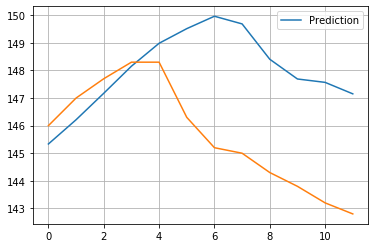

In [27]:
lst_days=[i for i in range(len(prediction1))]
plt.plot(prediction1, label='Prediction')
plt.plot(y_valid)
plt.legend()
plt.grid()

In [28]:
reg1_score = reg1.score(X_valid, y_valid)
reg1_mae, reg1_median_ae, reg1_max_error, reg1_error_sum = normalize_error(prediction1, y_valid)
print(reg1_score, reg1_mae, reg1_median_ae, reg1_max_error)

prediction1 = np.array(reg1.predict(X_test))

-2.123977722987771 2.682828951086208 3.553008878141071 4.764946316901785


In [29]:
var_model = XGBRegressor(n_jobs=-1, random_state=seed)
 
simple_space = {
#             'max_depth': np.arange(3, 15, dtype=int),
            'n_estimators': np.arange(50, 300, dtype=int),
            'learning_rate': uniform(0.01, 0.9),
#             'loss': ['linear', 'square', 'exponential'],
            'booster': ['gbtree', 'gblinear'],
            'eval_metric': ['rmse', 'mae'],
}

scoring = ['explained_variance']

best = RandomizedSearchCV(var_model, simple_space, scoring=scoring, cv=3, n_iter=10, n_jobs=-1,
                          random_state=seed, verbose=1, refit='explained_variance')
best.fit(hyperopt_X, hyperopt_y)
print("\nbest: ", best.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



best:  0.6269019627976762


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.7s finished


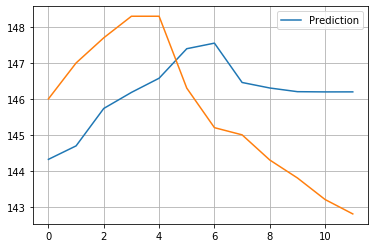

In [30]:
best_model_XGBRegressor = best.best_estimator_
best_model_XGBRegressor.fit(X_train, y_train)
prediction_xgb = best_model_XGBRegressor.predict(X_valid)
plt.plot(prediction_xgb, label='Prediction')
plt.plot(y_valid)
plt.legend()
plt.grid()

In [31]:
xgb_score = best_model_XGBRegressor.score(X_valid, y_valid)
print(xgb_score, normalize_error(prediction_xgb, y_valid))

-0.44344739069075856 (2.124944305419921, 2.0614852905273438, 3.3957092285156136, 10.402500653128008)


In [32]:
var_model = BaggingRegressor(base_estimator=best_model_XGBRegressor, random_state=seed, n_jobs=-1)
 
simple_space = {
            'n_estimators': np.arange(3, 23, dtype=int),
            'oob_score': [True, False],
            'bootstrap_features': [True, False],
            'bootstrap': [True, False],
}

# scoring = ['max_error']
scoring = ['explained_variance']

# verbose = 2 (print each epoch)
best = RandomizedSearchCV(var_model, simple_space, scoring=scoring, cv=3, n_iter=10, n_jobs=-1,
                          random_state=seed, verbose=1, refit='explained_variance')
best.fit(hyperopt_X, hyperopt_y)
print("\nbest: ", best.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.9s finished



best:  0.5974208994424568


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:1056: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:1056: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


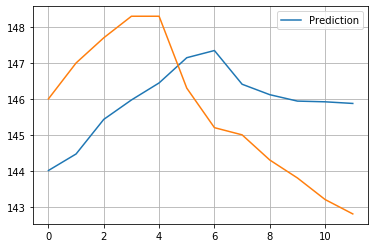

In [33]:
reg2 = best.best_estimator_
reg2 = reg2.fit(X_train, y_train)
prediction2 = reg2.predict(X_valid)
plt.plot(prediction2, label='Prediction')
plt.plot(y_valid)
plt.legend()
plt.grid()

In [34]:
reg2_score = reg2.score(X_valid, y_valid)
reg2_mae, reg2_median_ae, reg2_max_error, reg2_error_sum = normalize_error(prediction2, y_valid)
print(reg2_score, reg2_mae, reg2_median_ae, reg2_max_error)

prediction2 = reg2.predict(X_test)

-0.3895053146576517 2.094079589843749 2.14251708984375 3.073825073242176


In [35]:
var_model = RandomForestRegressor(n_jobs=-1, random_state=seed)

params = {
            'n_estimators':  [70, 150, 200],
            'max_depth': [3, 5, 10],
            'criterion': ['mse', 'mae'],
            'max_features': ['auto', 'sqrt', 'log2'],
}

best = GridSearchCV(var_model, params, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, verbose=1)
best.fit(hyperopt_X, hyperopt_y)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   28.1s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=1,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1

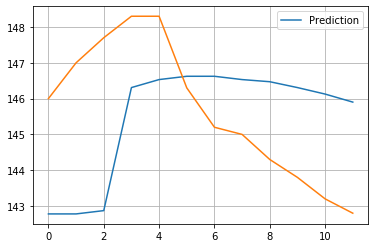

In [36]:
reg3 = best.best_estimator_
reg3 = reg3.fit(X_test, y_test)
prediction3 = np.array(reg3.predict(X_valid))
plt.plot(prediction3, label='Prediction')
plt.plot(y_valid)
plt.legend()
plt.grid()

In [37]:
reg3_score = reg3.score(X_valid, y_valid)
reg3_mae, reg3_median_ae, reg3_max_error, reg3_error_sum = normalize_error(prediction3, y_valid)
print(reg3_score, reg3_mae, reg3_median_ae, reg3_max_error)

prediction3 = np.array(reg3.predict(X_test))

-1.2717847351959137 2.501306944444449 2.3397916666667697 4.827983333333407


In [38]:
var_model = ARDRegression()
 
simple_space = {
            'n_iter': np.arange(300, 1700, dtype=int),
            'tol': uniform(0.0001, 0.01),
            'normalize': [True, False],
}

# scoring = ['neg_mean_absolute_error']
scoring = ['explained_variance']

# verbose = 2 (print each epoch)
best = RandomizedSearchCV(var_model, simple_space, scoring=scoring, cv=3, n_iter=15, n_jobs=-1,
                          random_state=seed, verbose=1, refit='explained_variance')
best.fit(hyperopt_X, hyperopt_y)
print("\nbest: ", best.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



best:  0.6959633088835692


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.2s finished


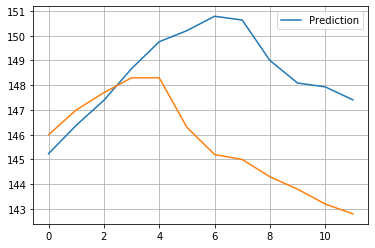

In [39]:
best_model = best.best_estimator_
best_model.fit(X_train, y_train)
model_prediction = best_model.predict(X_valid)
lst_days=[i for i in range(len(model_prediction))]
plt.plot(lst_days, model_prediction, label='Prediction')
plt.plot(lst_days, y_valid)
plt.legend()
plt.grid()

In [40]:
var_model = AdaBoostRegressor(base_estimator=best_model, random_state=seed)
 
simple_space = {
            'n_estimators': np.arange(3, 80, dtype=int),
            'learning_rate': uniform(0.001, 1.2),
            'loss': ['linear', 'square', 'exponential'],
}

scoring = ['explained_variance']

# verbose = 2 (print each epoch)
best = RandomizedSearchCV(var_model, simple_space, scoring=scoring, cv=3, n_iter=10, n_jobs=-1,
                          random_state=seed, verbose=1, refit='explained_variance')
best.fit(hyperopt_X, hyperopt_y)
print("\nbest: ", best.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    2.1s remaining:    0.6s



best:  0.7468370496996246


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.8s finished


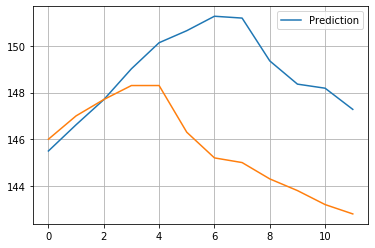

In [41]:
reg4 = best.best_estimator_
reg4 = reg4.fit(X_train, y_train)
prediction4 = np.array(reg4.predict(X_valid))
plt.plot(prediction4, label='Prediction')
plt.plot(y_valid)
plt.legend()
plt.grid()

In [42]:
reg4_score = reg4.score(X_valid, y_valid)
reg4_mae, reg4_median_ae, reg4_max_error, reg4_error_sum = normalize_error(prediction4, y_valid)
print(reg4_score, reg4_mae, reg4_median_ae, reg4_max_error)

prediction2 = np.array(reg4.predict(X_test))

-3.6684417644643417 3.2606509777282064 4.4138725016183145 6.189498396902934


In [43]:
var_model = SGDRegressor(shuffle=False, random_state=seed)
 
simple_space = {
            'max_iter': np.arange(5000, 10000, dtype=int),
            'l1_ratio': uniform(1e-2, 0.9),
            'tol': uniform(1e-4, 1e-2),
            'eta0': uniform(0.001, 0.1),
            'power_t': uniform(0.01, 0.3),
            'validation_fraction': uniform(0, 1),
            'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
            'penalty': ['l2', 'l1', 'elasticnet'],
            'loss': ['squared_loss', 'epsilon_insensitive', 'huber', 'squared_epsilon_insensitive'],
            'early_stopping': [True, False],
}

scoring = ['max_error']
# scoring = ['explained_variance']

# verbose = 2 (print each epoch)
best = RandomizedSearchCV(var_model, simple_space, scoring=scoring, cv=3, n_iter=25, n_jobs=-1,
                          random_state=seed, verbose=1, refit='max_error')
best.fit(hyperopt_X, hyperopt_y)
print("\nbest: ", best.best_score_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



best:  -4.4797564555349965


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   23.0s finished


In [44]:
sdgdregress = best.best_estimator_
sdgdregress.fit(X_train, y_train)
prediction_sdgdregress = sdgdregress.predict(X_valid)

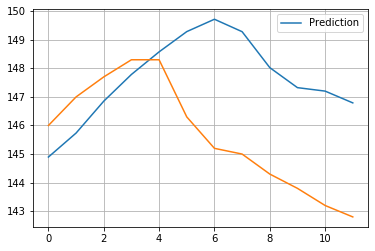

In [45]:
prediction_sdgdregress = np.array(prediction_sdgdregress)

plt.plot(prediction_sdgdregress, label='Prediction')
plt.plot(y_valid)
plt.legend()
plt.grid()

In [46]:
var_model = BaggingRegressor(base_estimator=sdgdregress, random_state=seed, n_jobs=-1)
 
simple_space = {
            'n_estimators': np.arange(3, 35, dtype=int),
            'bootstrap_features': [True, False],
            'oob_score': [True, False],
            'bootstrap': [True, False],
}

scoring = ['max_error']
# scoring = ['explained_variance']

# verbose = 2 (print each epoch)
best = RandomizedSearchCV(var_model, simple_space, scoring=scoring, cv=3, n_iter=13, n_jobs=-1,
                          random_state=seed, verbose=1, refit='max_error')
best.fit(hyperopt_X, hyperopt_y)
print("\nbest: ", best.best_score_)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



best:  -3.046742851596567


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.1s finished


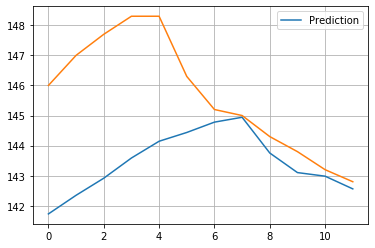

In [47]:
reg5 = best.best_estimator_
reg5 = reg5.fit(X_train, y_train)
prediction5 = np.array(reg5.predict(X_valid))
plt.plot(prediction5, label='Prediction')
plt.plot(y_valid)
plt.legend()
plt.grid()

In [48]:
reg5_score = reg5.score(X_valid, y_valid)
reg5_mae, reg5_median_ae, reg5_max_error, reg5_error_sum = normalize_error(prediction5, y_valid)
print(reg5_score, reg5_mae, reg5_median_ae, reg5_max_error)

prediction7 = np.array(reg5.predict(X_test))

-1.6284059109591404 2.21715968055152 1.279663876213391 4.783081335990801


# **Результат на тестовой выборке**

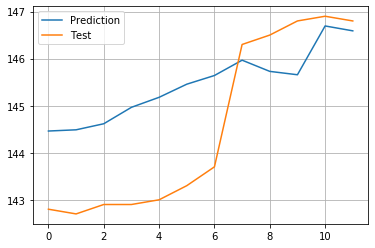

In [49]:
prediction_and_max_error = {
    reg1_error_sum: prediction1,
    reg2_error_sum: prediction2,
    reg3_error_sum: prediction3,
    reg4_error_sum: prediction4,
    reg5_error_sum: prediction5,
}

weights = len(prediction_and_max_error)
sum_weights = sum([i for i in range(weights + 1)])

combine_prediction = 0
for k in sorted(prediction_and_max_error.keys()):
    combine_prediction += prediction_and_max_error[k] * weights
    weights -= 1
    
combine_prediction /= sum_weights

plt.plot(combine_prediction, label='Prediction')
plt.plot(y_test, label='Test')
plt.legend()
plt.grid()

In [50]:
combine_regr_mae = mean_absolute_error(y_test, combine_prediction)
combine_regr_median_ae = median_absolute_error(y_test, combine_prediction)
combine_regr_max_error = max_error(y_test, combine_prediction)
regr_std = explained_variance_score(y_test, combine_prediction)
print(combine_regr_mae, combine_regr_median_ae, combine_regr_max_error, regr_std)

1.347338906684224 1.6884103804477917 2.177544808151822 0.5239351691124834
